# Tutorial 33: Risk Parity with Constraints using the Risk Budgeting Approach

## 1. Downloading the data:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%%**********************]  25 of 25 completed


In [2]:
# Calculating returns

Y = data[assets].pct_change().dropna()

display(Y.head())

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-2.0257%,0.4057%,0.4036%,1.9693%,0.0180%,0.9305%,0.3678%,0.5784%,0.9482%,-1.1953%,...,1.5881%,0.0212%,2.8236%,0.9758%,0.6987%,1.7539%,-0.1730%,0.2409%,1.3734%,-1.0857%
2016-01-06,-11.4863%,-1.5879%,0.2411%,-1.7557%,-0.7727%,-1.2473%,-0.1736%,-1.1239%,-3.5867%,-0.9551%,...,0.5547%,0.0212%,0.1592%,-1.5647%,0.3108%,-1.0155%,-0.7653%,-3.0048%,-0.9035%,-2.9145%
2016-01-07,-5.1388%,-4.1922%,-1.6573%,-2.7699%,-1.1047%,-1.9769%,-1.2206%,-0.8855%,-4.6058%,-2.5394%,...,-2.2066%,-3.0309%,-1.0411%,-3.1556%,-1.6148%,-0.2700%,-2.2845%,-2.0570%,-0.5492%,-3.0019%
2016-01-08,0.2736%,-2.2705%,-1.6037%,-2.5425%,0.1098%,-0.2241%,0.5706%,-1.6402%,-1.7642%,-0.1649%,...,-0.1538%,-1.1366%,-0.7308%,-0.1449%,0.0895%,-3.3838%,-0.1117%,-1.1387%,-0.9719%,-1.1254%
2016-01-11,-4.3383%,0.1692%,-1.6851%,-1.0215%,0.0915%,-1.1791%,0.5674%,0.5287%,0.6616%,0.0330%,...,1.6435%,0.0000%,0.9869%,-0.1450%,1.2224%,1.4570%,0.5367%,-0.4607%,0.5800%,-1.9919%


## 2. Estimating Vanilla Risk Parity Portfolio

### 2.1 Calculating the vanilla risk parity portfolio.

In [3]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:

model = 'Classic' # Could be Classic (historical) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
b = None # Risk contribution constraints vector

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_rp.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,2.4030%,3.0789%,4.0266%,4.1195%,3.8922%,5.2037%,5.1027%,3.0419%,2.8335%,3.6087%,...,6.5391%,2.9903%,6.8692%,3.5366%,4.5882%,3.9739%,3.4290%,2.9490%,5.1896%,2.9995%


### 2.2 Plotting portfolio composition

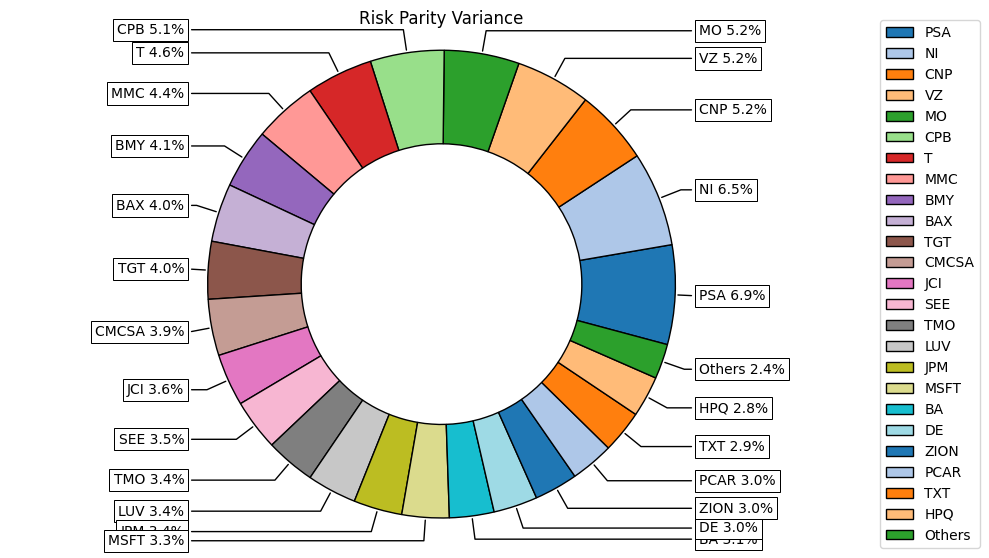

In [4]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w_rp, title='Risk Parity Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### 2.3 Plotting Risk Composition

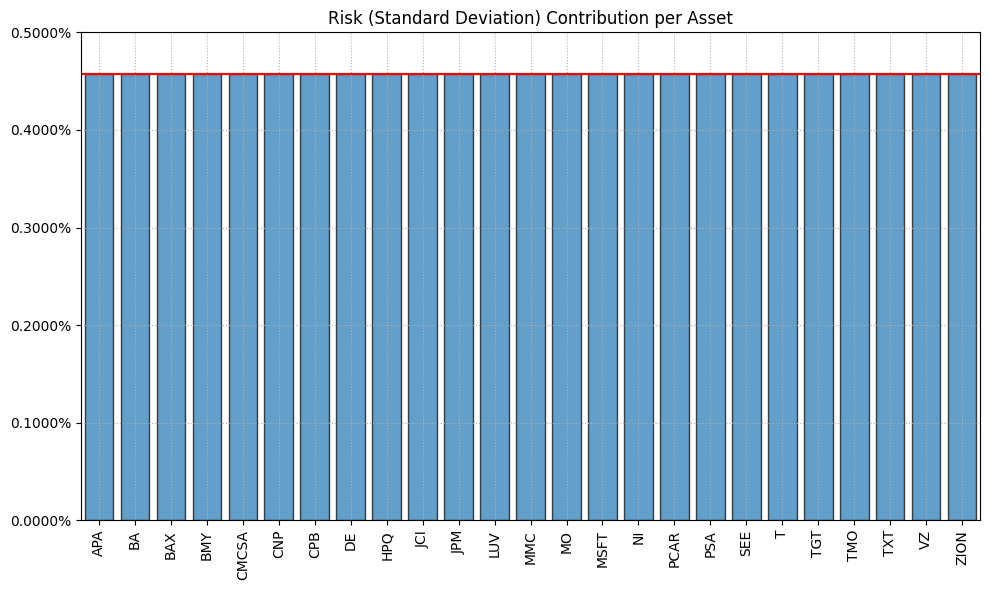

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,6))

# Plotting the risk composition of the portfolio
ax = rp.plot_risk_con(w_rp, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.05,
                      color="tab:blue", height=6, width=10, ax=ax)

# Plotting equal risk contribution line
a1 = rp.Sharpe_Risk(w_rp, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.05)
ax.axhline(y=a1/len(assets) * 252**0.5, color='r', linestyle='-')

plt.show()

## 3. Estimating Risk Parity Portfolios with Return Constraint

이 부분에서는 Richard와 Roncalli(2019)의 위험 예산 접근 방식을 사용하여 수익률 제약 조건을 추가한 리스크 균형 포트폴리오를 계산할 것입니다.

### 위험 예산 접근 방식

**위험 예산(Risk Budgeting) 접근 방식**:
- 위험 예산 접근 방식은 각 자산의 위험 기여도를 미리 설정된 예산 비율에 맞추어 포트폴리오를 구성합니다.
- 이는 리스크 균형 포트폴리오의 변형으로, 각 자산이 포트폴리오 전체 리스크에 기여하는 비율을 조정하여 목표로 하는 리스크 예산에 맞춥니다.

### 예제 코드

다음은 위험 예산 접근 방식을 사용하여 수익률 제약 조건을 추가한 리스크 균형 포트폴리오를 계산하는 예제 코드입니다.

```python
import numpy as np
import pandas as pd
import riskfolio as rp

# 예시 데이터 생성
np.random.seed(42)
Y = np.random.randn(100, 10)  # 100개의 샘플과 10개의 자산
asset_names = [f'Asset {i}' for i in range(1, 11)]
returns = pd.DataFrame(Y, columns=asset_names)

# 포트폴리오 객체 생성
port = rp.Portfolio(returns=returns)

# 기대 수익률과 공분산 행렬 계산
method_mu = 'hist'
method_cov = 'hist'
port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# 수익률 제약 조건 설정
port.lowerret = 0.00056488 * 1.5

# 위험 예산 벡터 설정
risk_budget = np.array([0.1]*10)  # 각 자산에 대한 동일한 위험 예산 (예시)

# 리스크 균형 포트폴리오 최적화
w_rb = port.rp_optimization(model='Classic', rm='MV', rf=0, b=risk_budget, hist=True)

# 결과 출력
print("Optimal weights with return constraint using Risk Budgeting approach:\n", w_rb.T)
```

### 코드 설명

1. **데이터 생성**:
   ```python
   np.random.seed(42)
   Y = np.random.randn(100, 10)  # 100개의 샘플과 10개의 자산
   asset_names = [f'Asset {i}' for i in range(1, 11)]
   returns = pd.DataFrame(Y, columns=asset_names)
   ```

   - 예시 데이터를 생성하고 자산 이름을 설정합니다.

2. **포트폴리오 객체 생성 및 통계 계산**:
   ```python
   port = rp.Portfolio(returns=returns)
   method_mu = 'hist'
   method_cov = 'hist'
   port.assets_stats(method_mu=method_mu, method_cov=method_cov)
   ```

   - `Portfolio` 객체를 생성하고, 자산의 기대 수익률과 공분산 행렬을 계산합니다.

3. **수익률 제약 조건 설정**:
   ```python
   port.lowerret = 0.00056488 * 1.5
   ```

   - 포트폴리오의 최소 수익률 제약 조건을 설정합니다.

4. **위험 예산 벡터 설정**:
   ```python
   risk_budget = np.array([0.1]*10)  # 각 자산에 대한 동일한 위험 예산 (예시)
   ```

   - 각 자산에 대한 위험 예산 비율을 설정합니다. 여기서는 모든 자산에 동일한 위험 예산을 설정합니다.

5. **리스크 균형 포트폴리오 최적화**:
   ```python
   w_rb = port.rp_optimization(model='Classic', rm='MV', rf=0, b=risk_budget, hist=True)
   ```

   - `rp_optimization` 메서드를 사용하여 리스크 균형 포트폴리오를 최적화합니다.
   - `model='Classic'`: 클래식 모델을 사용합니다.
   - `rm='MV'`: 평균-분산을 위험 측정치로 사용합니다.
   - `rf=0`: 무위험 이자율을 0으로 설정합니다.
   - `b=risk_budget`: 위험 예산 벡터를 설정합니다.
   - `hist=True`: 역사적 데이터를 사용합니다.

6. **결과 출력**:
   ```python
   print("Optimal weights with return constraint using Risk Budgeting approach:\n", w_rb.T)
   ```

   - 최적화된 포트폴리오 가중치를 출력합니다.

### 결론

이 코드는 Richard와 Roncalli(2019)의 위험 예산 접근 방식을 사용하여 수익률 제약 조건을 추가한 리스크 균형 포트폴리오를 계산하는 방법을 보여줍니다. 위험 예산 접근 방식은 각 자산의 위험 기여도를 미리 설정된 예산 비율에 맞추어 포트폴리오를 구성하는 방법으로, 리스크 균형 포트폴리오의 변형입니다. 이를 통해 투자자는 각 자산의 리스크 기여도를 조절하여 포트폴리오의 리스크를 효과적으로 관리할 수 있습니다.

### 3.1 Calculating the risk parity portfolio for variance.

In [6]:
# Setting the return constraint
port.lowerret = 0.00056488 * 1.5

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_rp.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,1.0014%,7.3678%,6.1727%,1.5336%,2.8250%,3.4616%,1.7765%,6.2117%,3.1583%,2.2340%,...,3.1261%,2.9912%,1.5687%,1.3347%,2.4554%,4.9581%,5.2073%,1.3174%,2.8315%,3.5269%


### 3.2 Plotting portfolio composition

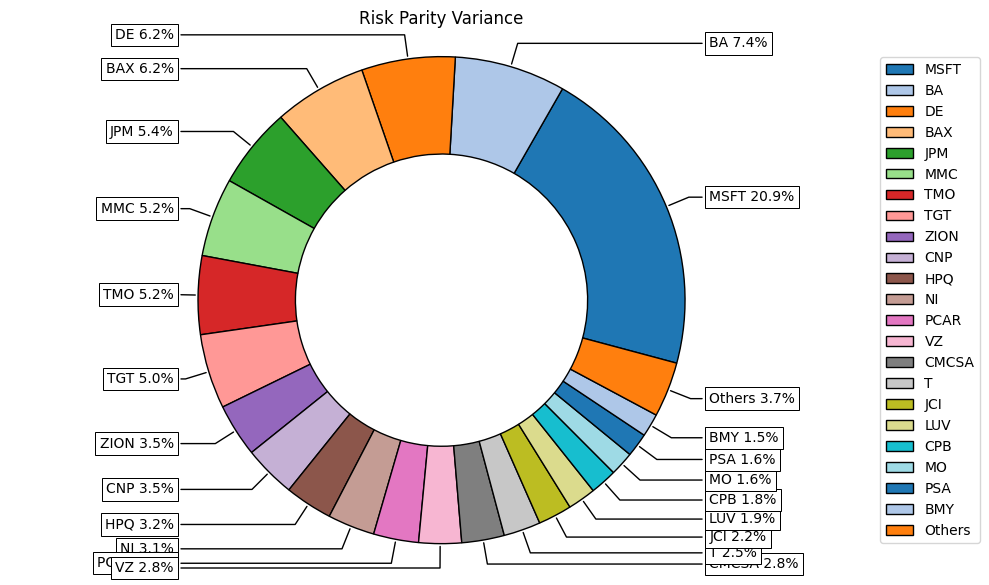

In [7]:
ax = rp.plot_pie(w=w_rp, title='Risk Parity Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### 3.3 Plotting Risk Composition

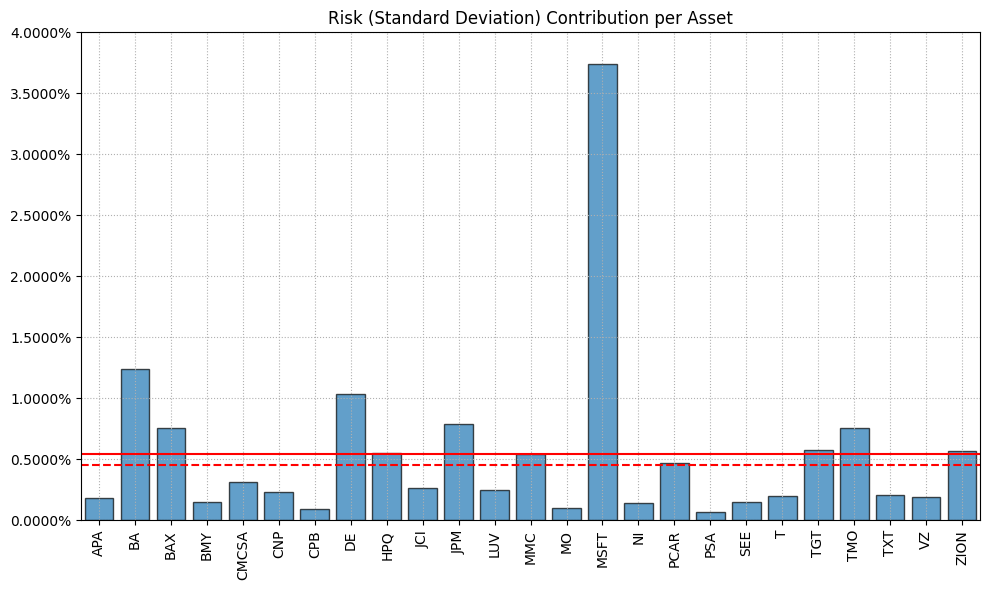

In [10]:
fig, ax = plt.subplots(figsize=(10,6))

# Plotting the risk composition of the portfolio
ax = rp.plot_risk_con(w_rp, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=ax)

# Plotting equal risk contribution line
ax.axhline(y=a1/len(assets) * 252**0.5, color='r', linestyle='--')

plt.show()

## 4. Estimating Risk Parity Portfolios with Linear Constraints

이 부분에서는 Richard와 Roncalli(2019)의 위험 예산 접근 방식을 사용하여 수익률 제약 조건과 추가적인 선형 제약 조건을 포함한 리스크 균형 포트폴리오를 계산할 것입니다.

### 4.1 Building the Linear Constraints

In [12]:
asset_classes = {'Assets': ['JCI','TGT','CMCSA','CPB','MO','APA','MMC','JPM',
                            'ZION','PSA','BAX','BMY','LUV','PCAR','TXT','TMO',
                            'DE','MSFT','HPQ','SEE','VZ','CNP','NI','T','BA'], 
                 'Industry': ['Consumer Discretionary','Consumer Discretionary',
                              'Consumer Discretionary', 'Consumer Staples',
                              'Consumer Staples','Energy','Financials',
                              'Financials','Financials','Financials',
                              'Health Care','Health Care','Industrials','Industrials',
                              'Industrials','Health Care','Industrials',
                              'Information Technology','Information Technology',
                              'Materials','Telecommunications Services','Utilities',
                              'Utilities','Telecommunications Services','Financials']}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])
display(asset_classes)

constraints = {'Disabled': [False, False, False, False, False],
               'Type': ['All Assets', 'Classes', 'Classes', 'Classes',
                        'Classes'],
               'Set': ['', 'Industry', 'Industry', 'Industry', 'Industry'],
               'Position': ['', 'Financials', 'Utilities', 'Industrials',
                            'Consumer Discretionary'],
               'Sign': ['<=', '<=', '<=', '<=', '<='],
               'Weight': [0.10, 0.2, 0.2, 0.2, 0.2],
               'Type Relative': ['', '', '', '', ''],
               'Relative Set': ['', '', '', '', ''],
               'Relative': ['', '', '', '', ''],
               'Factor': ['', '', '', '', '']}

constraints = pd.DataFrame(constraints)

display(constraints)

,Assets,Industry
5,APA,Energy
24,BA,Financials
10,BAX,Health Care
11,BMY,Health Care
2,CMCSA,Consumer Discretionary
21,CNP,Utilities
3,CPB,Consumer Staples
16,DE,Industrials
18,HPQ,Information Technology
0,JCI,Consumer Discretionary


,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,All Assets,,,<=,10.0000%,,,,
1,False,Classes,Industry,Financials,<=,20.0000%,,,,
2,False,Classes,Industry,Utilities,<=,20.0000%,,,,
3,False,Classes,Industry,Industrials,<=,20.0000%,,,,
4,False,Classes,Industry,Consumer Discretionary,<=,20.0000%,,,,


### 4.2 Calculating the risk parity portfolio with linear constraints

In [13]:
A, B = rp.assets_constraints(constraints, asset_classes)

port.ainequality = A
port.binequality = B

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_rp.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.7532%,8.2376%,10.0000%,1.1661%,2.9070%,3.4145%,1.3134%,10.0000%,4.5709%,2.0166%,...,2.7000%,3.7168%,0.9177%,1.0012%,2.1024%,8.0299%,10.0000%,1.0388%,2.4952%,2.7303%


### 4.3 Plotting portfolio composition

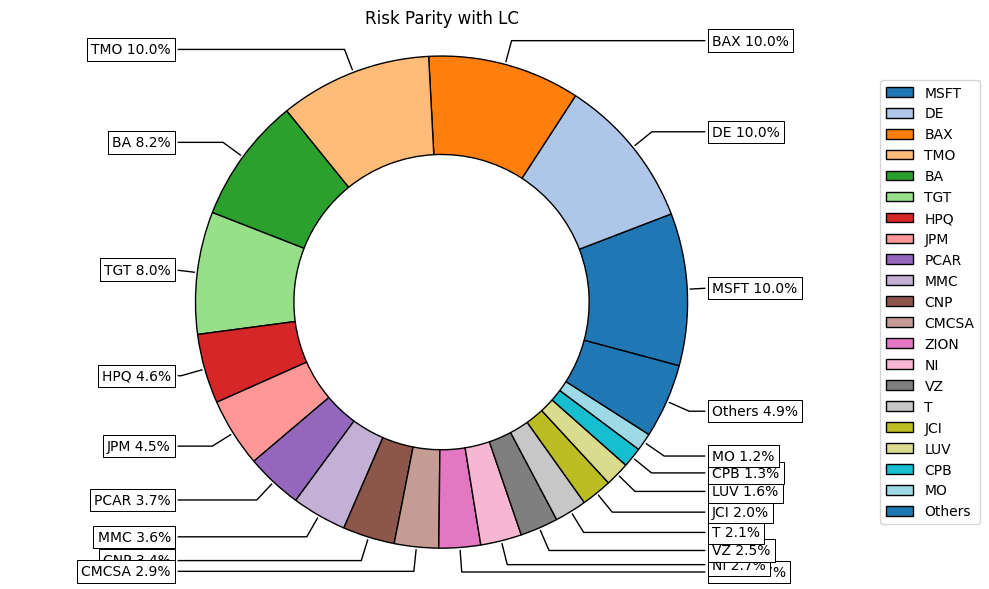

In [14]:
ax = rp.plot_pie(w=w_rp, title='Risk Parity with LC', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

In [15]:
w_classes = pd.concat([asset_classes.set_index('Assets'), w_rp], axis=1)
w_classes = w_classes.groupby(['Industry']).sum()

display(w_classes)

,weights
Industry,
Consumer Discretionary,12.9535%
Consumer Staples,2.4825%
Energy,0.7532%
Financials,20.0000%
Health Care,21.1661%
Industrials,16.3605%
Information Technology,14.5709%
Materials,1.0012%
Telecommunications Services,4.5976%


### 4.4 Plotting Risk Composition

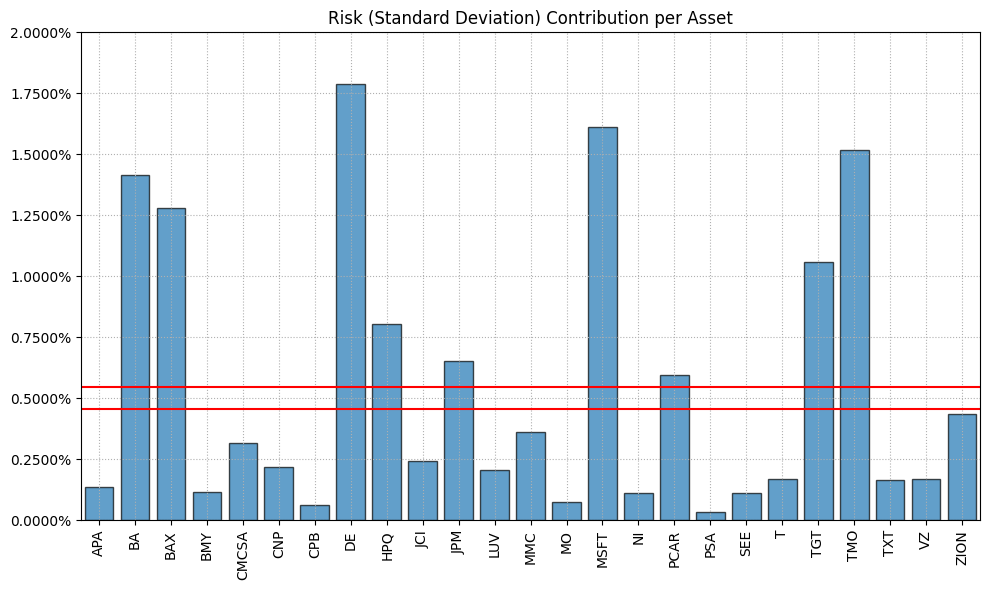

In [16]:
fig, ax = plt.subplots(figsize=(10,6))

# Plotting the risk composition of the portfolio
ax = rp.plot_risk_con(w_rp, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=ax)

# Plotting equal risk contribution line
ax.axhline(y=a1/len(assets) * 252**0.5, color='r', linestyle='-')

plt.show()